# Testing
---
This notebook will be my testing method until one test becomes too big to handle

In [1]:
from qiskit.quantum_info import Pauli,SparsePauliOp,Statevector
from colorama import Fore
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram

In [2]:
psi = Statevector.from_int(4,dims=8)
psi

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [3]:
pl = Pauli('ZZI')

print(pl.to_matrix(sparse=True))

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 8 stored elements and shape (8, 8)>
  Coords	Values
  (0, 0)	(1+0j)
  (1, 1)	(1+0j)
  (2, 2)	(-1+0j)
  (3, 3)	(-1+0j)
  (4, 4)	(-1+0j)
  (5, 5)	(-1+0j)
  (6, 6)	(1+0j)
  (7, 7)	(1+0j)


In [10]:
H_cut = SparsePauliOp(Pauli('ZZI'))+ SparsePauliOp(Pauli('ZIZ'))

print("H_cut is")
print(H_cut)
print("The sparse representation of H_cut is")
print(H_cut.to_matrix(sparse=True))

H_cut is
SparsePauliOp(['ZZI', 'ZIZ'],
              coeffs=[1.+0.j, 1.+0.j])
The sparse representation of H_cut is
  (0, 0)	(2+0j)
  (1, 1)	0j
  (2, 2)	0j
  (3, 3)	(-2+0j)
  (4, 4)	(-2+0j)
  (5, 5)	0j
  (6, 6)	0j
  (7, 7)	(2+0j)


In [18]:
psi.expectation_value(H_cut).real

-2.0

## Quantum Annealer

In this part of the notebook, we try the Ocean framework, to work with quantum annealers 

In [2]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite

In [ ]:
# Coefficients of the quadratic term elements (squared or products)
J = {(0,1):1, (0,2):1}
# Coefficients of the linear terms
h = {}
problem = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
print("The problem we are going to solve is:")
print(problem)


The problem we are going to solve is:
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0}, {(1, 0): 1.0, (2, 0): 1.0}, 0.0, 'SPIN')


In [ ]:
# You need to have an access token configured
# sampler = EmbeddingComposite(DWaveSampler())
# result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

The solutions that we have obtained are
   0  1  2 energy num_oc. chain_.
0 -1 +1 +1   -2.0       4     0.0
1 +1 -1 -1   -2.0       6     0.0
['SPIN', 2 rows, 10 samples, 3 variables]


In [4]:
result.info['timing']['qpu_access_time']

16583.76

Using `dimod` we can also solve binary problems without having to rewrite them in the QUBO or Ising model form. To test this we will solve the next minimization problem:

\begin{aligned}   
        \text{Minimize } \quad -5x_0+3x_1-2x_2\\
        \text{Subject to }\qquad \qquad x_0 + x_2 \leq 1,\\
        3x_0 − x_1 + 3x_2 \leq 4 \\
        \vec{x} \in \{0,1\}^3
    \end{aligned}

In [42]:
from dimod import Binary

x0 = Binary("x0")
x1 = Binary("x1")
x2 = Binary("x2")

# Define the problem (objective and constraints)
blp = dimod.ConstrainedQuadraticModel()

blp.set_objective(-5*x0+3*x1-2*x2)
blp.add_constraint(x0 + x2 <= 1, "First constraint")
blp.add_constraint(3*x0 -x1 + 3*x2 <= 4, "Second constraint")

print(f"Variables: {blp.variables}")
print(f"Objective: {blp.objective}")
print(f"Our constraints are: {blp.constraints}")

solver = dimod.ExactCQMSolver()

sol = solver.sample_cqm(blp)

# This calculates even non feasible solutions
print('Solutions')
print(sol,'\n')

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

Variables: Variables(['x0', 'x1', 'x2'])
Objective: ObjectiveView({'x0': -5.0, 'x1': 3.0, 'x2': -2.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'})
Our constraints are: {'First constraint': Le(ConstraintView({'x0': 1.0, 'x2': 1.0}, {}, 0.0, {'x0': 'BINARY', 'x2': 'BINARY'}), 1.0), 'Second constraint': Le(ConstraintView({'x0': 3.0, 'x1': -1.0, 'x2': 3.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'}), 4.0)}
Solutions
  x0 x1 x2 energy num_oc. is_sat. is_fea.
6  1  0  1   -7.0       1 arra...   False
2  1  0  0   -5.0       1 arra...    True
7  1  1  1   -4.0       1 arra...   False
3  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       1 arra...    True
0  0  0  0    0.0       1 arra...    True
5  0  1  1    1.0       1 arra...    True
1  0  1  0    3.0       1 arra...    True
['INTEGER', 8 rows, 8 samples, 3 variables] 

Best Solution
Variables: {'x0': 1, 'x1': 0, 'x2': 0}, Cost = -5.0


However, using this we dont use quantum annealers, to do that we can transform the problem to a QUBO using Ocean functions.

In [ ]:
qubo, invert = dimod.cqm_to_bqm(blp,lagrange_multiplier = 5)

# print(qubo) # Quite ugly output

# Uncomment to execute
# sampler = EmbeddingComposite(DWaveSampler())
# result = sampler.sample(qubo,num_reads=10)

print('Solutions')
print(result)

Solutions
  slack_v050645ea8f4d4fa59dfae269a2016c91_0 ... x2 energy num_oc. chain_.
0                                         0 ...  1   -2.0       1     0.0
1                                         0 ...  0   -2.0       1     0.0
2                                         0 ...  0    0.0       1     0.0
3                                         0 ...  0    0.0       2     0.0
4                                         0 ...  1    3.0       2     0.0
5                                         1 ...  0    5.0       1     0.0
6                                         1 ...  1    8.0       1     0.0
7                                         1 ...  1   21.0       1     0.0
['BINARY', 8 rows, 10 samples, 7 variables]


By using the QA we get the solutions from the transformed problem, we can obtain the solutions from the original problem by untransforming

In [55]:
samples = []
occurrences = []

for s in result.data():
    samples.append(invert(s.sample))
    occurrences.append(s.num_occurrences)
    sampleset = dimod.SampleSet.from_samples_cqm(samples,blp,num_occurrences=occurrences)
    
print("The solutions to the original problem are")
print(sampleset,'\n')

feas_sol = sampleset.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

The solutions to the original problem are
  x0 x1 x2 energy num_oc. is_sat. is_fea.
2  1  0  0   -5.0       1 arra...    True
3  1  0  0   -5.0       2 arra...    True
7  1  1  1   -4.0       1 arra...   False
0  0  0  1   -2.0       1 arra...    True
1  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       2 arra...    True
6  0  0  1   -2.0       1 arra...    True
5  0  0  0    0.0       1 arra...    True
['INTEGER', 8 rows, 10 samples, 3 variables] 

Best Solution
Variables: {'x0': 1, 'x1': 0, 'x2': 0}, Cost = -5.0


As we can see, we get the same solutions, with the observation that we get the best solution ($x_0=1, x_1=x_2=0$) more than any other answer.

---
Using properties from the `dimod` package, we can change the multiple parameters that define the QA, maybe even obtaining better solutions for the problems. However, the scope of this work is not to use QA, rather **Quantum Approximate Optimization Algorithm** or **QAOA** to run the simulation on a general purpose QPU. We will be using **Qiskit** again.

## QAOA

As we will be using this disposition of gates multiple times, we create a function

In [2]:
def interaction_term(qc: QuantumCircuit, phi, control, target)->QuantumCircuit:
    """
    Builds the gate from the interaction term in the Ising Hamiltonian
    
    Args:
        `qc`: The quantum circuit to be added
        `phi`: The parameter $\phi$ from the optimization
        `control`: The position of the control qubit
        `target`: The position of the target qubit
    
    Returns:
        The modified QuantumCircuit
    
    """
    
    qc.cx(control,target)
    qc.rz(phi*2,target)
    qc.cx(control,target)
    qc.barrier()
    
    return qc

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\nicolas.fernandez\AppData\Local\Temp\ipykernel_13516\1012078355.py:2: SyntaxWarning: invalid escape sequence '\p'
  """


In [3]:
# Function to automatize layers of an ansatz
def create_ansatz_layer(qc:QuantumCircuit,expression:str,x=1)->QuantumCircuit:
    
    expression = expression.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    expression = expression.replace('-', '+-')
    if expression[0] == '+':
        expression = expression[1:]
    
    # Split the string into terms
    terms = expression.split('+')
    
    for term in terms:
        gate = term.count('Z')
        coefs = term.split('Z')
        if coefs[0] == '':
            coefs[0]=1
        if coefs[0] == '-':
            coefs[0]=-1
        coefs = [int(t) for t in coefs]
        if gate == 1:
            qc.rz(2*coefs[0]*x,coefs[1])
            qc.barrier()
        else:
            qc = interaction_term(qc,coefs[0]*x,coefs[1],coefs[2])
    return qc

This is a test to write a QAOA circuit for a simple Hamiltonian $H_1=Z_1𝑍_3 + 𝑍_0𝑍_2 − 2𝑍_1 + 3𝑍_2$ with $𝑝 = 1$ (AKA one layer). As we only have 1 layer we will need 2 parameters: $\beta$ and $\gamma$. In this example we are already using the function that creates an ansatz from a ising hamiltonian.

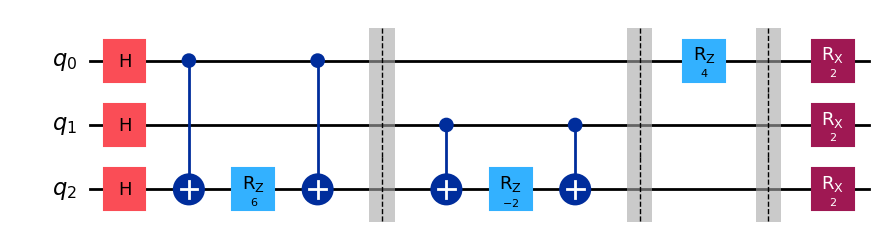

In [4]:
expression = '3Z0Z2-Z1Z2+2Z0'
size = 3
qc = QuantumCircuit(size)
for i in range(size):
    qc.h(i)
qc =  create_ansatz_layer(qc,expression)
for i in range(size):
    qc.rx(2,i)
qc.draw('mpl')

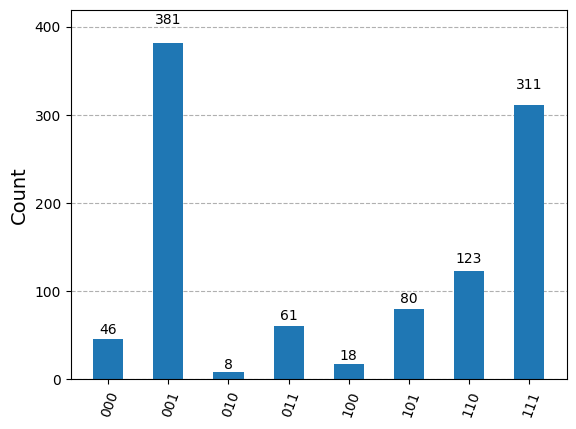

In [5]:
sim = AerSimulator()
qc.measure_all()
qc = transpile(qc,sim)

sampler = SamplerV2()
shots =1028

job = sampler.run([qc],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
plot_histogram(counts)

### Time test

In order to calculate the energy of the system you have to compute multiple matrix products, however the matrices we are working with are diagonal, so we try to create a more efficient method. Moreover, we are working with states from the computational basis, meaning every position is a 0 so:

$\bra{a}H_1\ket{a}=H_{jj}$, as $a_j=1$.

With this in mind and knowing that:

$\bra{a}Z_jZ_k\ket{a}=\pm1$

We can obtain the energy without having to calculate any matrix products.

In [6]:
def eval_energy(expression:str,factor:str):
    energy = 0
    
    expression = expression.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    expression = expression.replace('-', '+-')
    if expression[0] == '+':
        expression = expression[1:]
    
    # Split the string into terms
    terms = expression.split('+')
    
    
    for term in terms:
        gate = term.count('Z')
        coefs = term.split('Z')
        if coefs[0] == '':
            coefs[0]=1
        if coefs[0] == '-':
            coefs[0]=-1
        coefs = [int(x) for x in coefs]
        if gate == 1:
            energy += (-2*int(factor[coefs[1]])+1)*coefs[0]
        else:
            energy += (2*np.abs(int(factor[coefs[1]])+int(factor[coefs[2]])-1)-1)*coefs[0]
    
    return energy

In [9]:
eval_energy('Z1Z3+Z0Z2-2Z1+3Z2','1011')

np.int64(-5)

Using what we know this should be the energy expectation using the parameters $\beta=\gamma=1$ with one layer.

In [10]:
energy = 0
for key in counts:
    energy+= counts[key]*eval_energy(expression,key)/shots
    
print(energy)

-0.32101167315175105


In [11]:
def f_to_minimize(x):
    expression = 'Z0Z1'
    size = 2
    qc = QuantumCircuit(size)
    for i in range(size):
        qc.h(i)
    qc =  create_ansatz_layer(qc,expression,x[0])
    for i in range(size):
        qc.rx(2*x[1],i)
        sim = AerSimulator()
    qc.measure_all()
    qc = transpile(qc,sim)

    sampler = SamplerV2()
    shots =128

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()
    
    energy = 0
    for key in counts:
        energy+= counts[key]*eval_energy(expression,key)/shots
        
    return energy

In [12]:
import scipy
import scipy.optimize

initial_params = np.random.rand(2)

print(f'Initial parameters: beta={initial_params[0]}, gamma={initial_params[1]}')

result = scipy.optimize.minimize(fun=f_to_minimize,method='COBYLA',x0=initial_params)

print("Optimal value:", result.fun)
print("Optimal parameters:", result.x)

Initial parameters: beta=0.7550898879235483, gamma=0.4956495735201347
Optimal value: -0.875
Optimal parameters: [2.63913957 0.37588648]


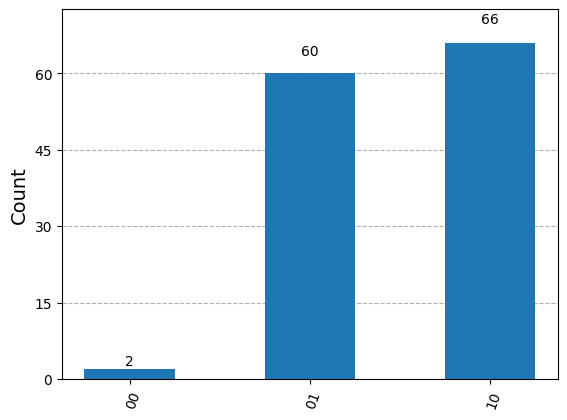

In [13]:
expression = 'Z0Z1'
size = 2
qc = QuantumCircuit(size)
for i in range(size):
    qc.h(i)
qc =  create_ansatz_layer(qc,expression,0.6431375)
for i in range(size):
    qc.rx(2*1.17460945,i)
    sim = AerSimulator()
qc.measure_all()

sampler = SamplerV2()
shots =128

job = sampler.run([qc],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()

plot_histogram(counts)

We know that in this problem we have 2 optimal solutions: **01** and **10**, that are the only results that we measure in the last iteration, with a energy level of $-0.96$. This should mean that the methods are working fine. 

Definitely..., very likely..., likely..., probably..., presumably..., plausibly..., possibly..., conceivably..., maybe..., 
uncertainly..., questionably..., doubtfully..., improbably..., remotely..., dubiously..., implausibly...

Seriously, I don't know if it works, it seems to work, but there is a high variability of the optimum parameters, I'm also getting substantially different results from the ones in the book, so I don't know. They also get totally different parameter values when running in a QPU, so at least I got that. At least the energy level seems consistent.

---

I'm going to try another example, where I know the optimal is **100**.

In [20]:
def f_to_minimize(x):
    expression = '3Z0Z2-Z1Z2+2Z0'
    size = 3
    qc = QuantumCircuit(size)
    for i in range(size):
        qc.h(i)
    qc =  create_ansatz_layer(qc,expression,x[0])
    for i in range(size):
        qc.rx(2*x[1],i)
        sim = AerSimulator()
    qc.measure_all()
    qc = transpile(qc,sim)

    sampler = SamplerV2()
    shots =128

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()
    
    energy = 0
    for key in counts:
        energy+= counts[key]*eval_energy(expression,key)/shots
        
    return energy


initial_params = np.random.rand(2)

print(f'Initial parameters: beta={initial_params[0]}, gamma={initial_params[1]}')

result = scipy.optimize.minimize(fun=f_to_minimize,method='COBYLA',x0=initial_params)

print("Optimal value:", result.fun)
print("Optimal parameters:", result.x)

Initial parameters: beta=0.993611649630799, gamma=0.09200005440720027
Optimal value: -1.796875
Optimal parameters: [ 0.2540503  -0.51347887]


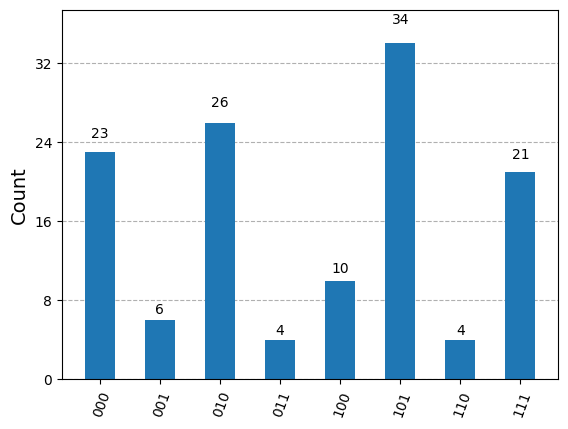

In [31]:
expression = '3Z0Z2-Z1Z2+2Z0'
size = 3
qc = QuantumCircuit(size)
for i in range(size):
    qc.h(i)
qc =  create_ansatz_layer(qc,expression,result.x[0])
for i in range(size):
    qc.rx(2*-result.x[1],i)
    sim = AerSimulator()
qc.measure_all()

sampler = SamplerV2()
shots =128

job = sampler.run([qc],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()

plot_histogram(counts)

This is probably wrong.

---

I think I can also allow to input the Hamiltonian using Pauli Strings, as $Z_0Z_1$ in a 3 qubit system can be expressed as the Pauli String=$ZZI$. I wasn't sure if $Z_0Z_1=Z_1Z_0$, so I tested it implementing 2 circuits with inverted control and target qubits.

In [22]:
xz = 3* SparsePauliOp(Pauli('ZZI'))
st = Statevector.from_int(0,dims=8)
st = st.evolve(xz)
print(xz.to_matrix(sparse=True))
print(st)

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 8 stored elements and shape (8, 8)>
  Coords	Values
  (0, 0)	(3+0j)
  (1, 1)	(3+0j)
  (2, 2)	(-3+0j)
  (3, 3)	(-3+0j)
  (4, 4)	(-3+0j)
  (5, 5)	(-3+0j)
  (6, 6)	(3+0j)
  (7, 7)	(3+0j)
Statevector([3.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [23]:
sc = xz.to_list()[0][0].split('Z')
exp = ''
for i,term in enumerate(sc):
    if term == '':
        exp+='Z'+str(i)
print(exp)

Z0Z1


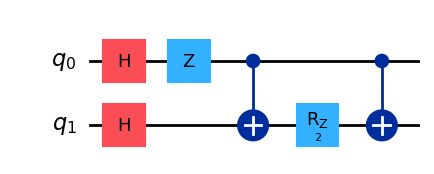

In [24]:
qc1 = QuantumCircuit(2)
for i in range(2):
    qc1.h(i)

qc1.z(0)
qc1.cx(0,1)
qc1.rz(2,1)
qc1.cx(0,1)

qc1.draw('mpl')    

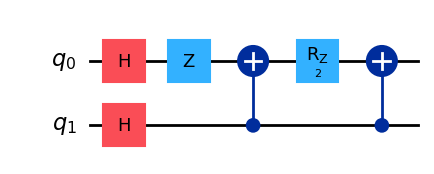

In [25]:
qc2 = QuantumCircuit(2)
for i in range(2):
    qc2.h(i)
qc2.z(0)
qc2.cx(1,0)
qc2.rz(2,0)
qc2.cx(1,0)

qc2.draw('mpl')  

In [26]:
st1 = Statevector(qc1)
st2 = Statevector(qc2)

print('First circuit:')
print(st1)
print('Second circuit:')
print(st2)

First circuit:
Statevector([ 0.27015115-0.42073549j, -0.27015115-0.42073549j,
              0.27015115+0.42073549j, -0.27015115+0.42073549j],
            dims=(2, 2))
Second circuit:
Statevector([ 0.27015115-0.42073549j, -0.27015115-0.42073549j,
              0.27015115+0.42073549j, -0.27015115+0.42073549j],
            dims=(2, 2))


In [27]:
qc1 = QuantumCircuit(3)
qc2 = QuantumCircuit(3)
for i in range(3):
    qc1.h(i)
    qc2.h(i)

expression1='3Z0Z2-Z1Z2+2Z0'
expression2='3Z2Z0-Z1Z2+2Z0'
    
qc1 = create_ansatz_layer(qc1,expression1)
qc2 = create_ansatz_layer(qc2,expression2)
for i in range(3):
    qc1.rx(2,i)
    qc2.rx(2,i)

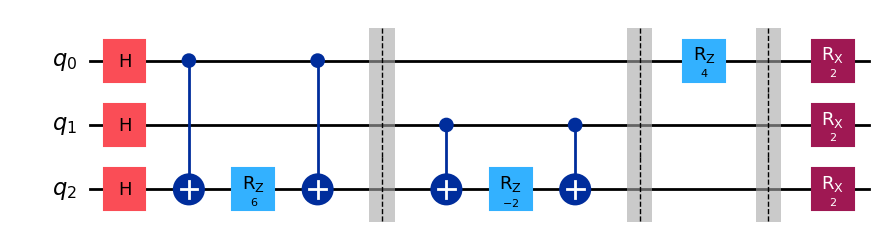

In [28]:
qc1.draw('mpl')

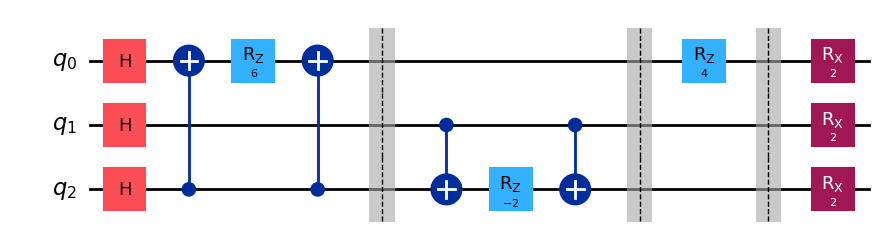

In [29]:
qc2.draw('mpl')

In [30]:
st1 = Statevector(qc1)
st2 = Statevector(qc2)

print('First circuit:')
print(st1)
print('Second circuit:')
print(st2)
print(f'Difference:{np.sum(st1.data-st2.data)}')

First circuit:
Statevector([ 0.16453747+0.10159367j, -0.61736941+0.00864046j,
             -0.07632849+0.11539155j,  0.16453747-0.1875438j ,
             -0.11408799-0.00864046j,  0.12677797-0.22852379j,
              0.29303294+0.11887458j, -0.56439292-0.00864046j],
            dims=(2, 2, 2))
Second circuit:
Statevector([ 0.16453747+0.10159367j, -0.61736941+0.00864046j,
             -0.07632849+0.11539155j,  0.16453747-0.1875438j ,
             -0.11408799-0.00864046j,  0.12677797-0.22852379j,
              0.29303294+0.11887458j, -0.56439292-0.00864046j],
            dims=(2, 2, 2))
Difference:0j


With this we confirm with high probability that the change is symmetrical, so We can implement the posibility to input the Ising Hamiltonian using Pauli Strings.

---

# BioPython / BLAST

In [2]:
from Bio import Align
from Bio.Align import substitution_matrices
from Bio import SeqIO
import numpy as np
import pandas as pd

# Load sequences from FASTA file
def load_sequences(fasta_file):
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Compute pairwise alignment scores using BLOSUM62 and normalizing as the paper do
def compute_distance_matrix(sequences):
    aligner = Align.PairwiseAligner()
    blosum62 = substitution_matrices.load("BLOSUM62")
    aligner.substitution_matrix = blosum62

    n = len(sequences)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i, j] = 0  # Distance with itself is 0                
            else:
                score = aligner.score(sequences[i], sequences[j])
                biti = aligner.score(sequences[i], sequences[i])
                bitj = aligner.score(sequences[j], sequences[j])
                # Convert score to a distance (example: max_score - score)
                distance_matrix[i, j] = 100*score/np.mean([biti,bitj])  # Negative alignment score for distance

    return distance_matrix

# Save the distance matrix as a CSV or visualize it
def save_distance_matrix(matrix, labels, output_file):
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    df.to_csv(output_file)
    print(f"Distance matrix saved to {output_file}")

# Main execution
fasta_file = "test.fasta" 
# output_file = "distance_matrix.csv"

sequences = load_sequences(fasta_file)
labels = [f"Seq{i+1}" for i in range(len(sequences))]
distance_matrix = compute_distance_matrix(sequences)
print(distance_matrix)
# save_distance_matrix(distance_matrix, labels, output_file)

[[ 0.         67.82608696 78.4        65.54621849]
 [67.82608696  0.         66.66666667 72.22222222]
 [78.4        66.66666667  0.         79.66101695]
 [65.54621849 72.22222222 79.66101695  0.        ]]


## Kinda proof

In [44]:
from dimod import BinaryQuadraticModel, BINARY

n = np.random.randint(3,10)
matrix = np.random.rand(n,n)*100
np.fill_diagonal(matrix,0) 
matrix = np.triu(matrix) + np.triu(matrix, 1).T 

rows = matrix.shape[0]
var = []

# if not tags:
for i in range(rows):
    var.append(dimod.Binary(i))
# else:
#     var = [dimod.Binary(i) for i in tags]
    
obj = BinaryQuadraticModel({},{},0.0,BINARY)

for i in range(rows):
    for j in range(i):
        obj+=matrix[i,j]*(var[i]-var[j])**2

suma = np.sum(var)      
# Add restriction term
# obj+=alpha*(suma-c)**2

problem = dimod.ConstrainedQuadraticModel()

problem.set_objective(obj)
print(problem)

solver = dimod.ExactCQMSolver()
sol = solver.sample_cqm(problem)

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print (feas_sol)

Constrained quadratic model: 9 variables, 0 constraints, 45 biases

Objective
  360.5215478829695*Binary(1) + 482.2225811746775*Binary(0) + 437.90652825761043*Binary(2) + 387.70395297362285*Binary(3) + 436.3714352710049*Binary(4) + 156.48227559187157*Binary(5) + 450.81015761026174*Binary(6) + 239.21891508030225*Binary(7) + 530.6517784791772*Binary(8) - 135.31810505126072*Binary(1)*Binary(0) - 57.96780548061275*Binary(1)*Binary(2) - 128.9964218872509*Binary(0)*Binary(2) - 129.1880453769479*Binary(1)*Binary(3) - 178.24312859891512*Binary(0)*Binary(3) - 11.192959808668457*Binary(2)*Binary(3) - 29.261859885079588*Binary(1)*Binary(4) - 138.89199666109943*Binary(0)*Binary(4) - 193.63476792709352*Binary(2)*Binary(4) - 188.70731667608607*Binary(3)*Binary(4) - 12.556388521594531*Binary(1)*Binary(5) - 30.801683414159008*Binary(0)*Binary(5) - 66.83292530709069*Binary(2)*Binary(5) - 37.08443526520375*Binary(3)*Binary(5) - 58.272139176653795*Binary(4)*Binary(5) - 96.6374344893705*Binary(1)*Binary(6

In [4]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.rx(2,0)
qc.rx(2,1)
tes=qc.draw('latex_source')
f = open('aux.tex','a+')
f.write(tes)
f.close()

In [5]:
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.rx(2,1)
qc.cx(0,1)
tes=qc.draw('latex_source')
f = open('aux.tex','a+')
f.write(tes)
f.close()

---
## Stuff for the presentation


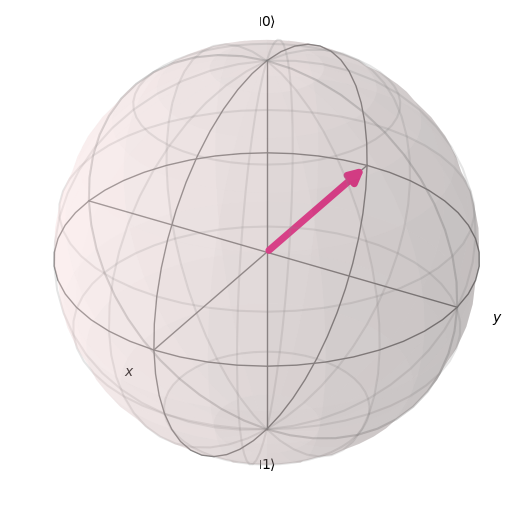

In [18]:
import numpy as np
from qiskit.visualization import plot_bloch_vector
cero = np.array([1,np.pi/2,np.pi])
uno = np.array([0,0,-1])

plot_bloch_vector(cero,coord_type='spherical')
# plot_bloch_vector(uno)